# Analysis of Deaths Due to Lung Disease in the US - 2005

In [1]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import linregress 
import requests
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from statsmodels.stats.proportion import proportions_ztest

In [2]:
#Definitions
PEAK_AGE = 74

In [3]:
# Load the clean 2005 data CSV file into a Pandas DataFrame
clean_2005_DD_df = pd.read_csv("cleaned_data_csv_files/clean_output_2005_DD_df.csv", low_memory=False)

# Display sample data
clean_2005_DD_df.head()

,Death in United States 2005,detail_age,detail_age_type_text,sex_text,race_text,marital_status_text,day_of_week_of_death_text,month_of_death_text,place_of_death_and_decedents_status_text,manner_of_death_text,358_cause_recode_text,130_infant_cause_recode_text
0,0,45,Years,Female,White,Married,Monday,January,"Hospital, clinic or Medical Center",Natural,Malignant melanoma of skin (C43),NaN
1,1,61,Years,Male,White,Divorced,Saturday,January,"Hospital, clinic or Medical Center",Natural,Emphysema (J43),NaN
2,2,79,Years,Female,White,Divorced,Sunday,January,Nursing home/long term care,Natural,Other cerebrovascular diseases and their seque...,NaN
3,3,50,Years,Male,White,"Never married, single",Wednesday,January,"Hospital, clinic or Medical Center",Natural,Diabetes mellitus (E10-E14),NaN
4,4,68,Years,Female,White,Married,Monday,January,"Hospital, clinic or Medical Center",Natural,"Of trachea, bronchus and lung (C33-C34)",NaN


In [4]:
#Reset index to use patient data ID numbers from original CSV, not arbitrary index assignments
clean_2005_DD_df = clean_2005_DD_df.drop(columns=["Death in United States 2005"])
clean_2005_DD_df


,detail_age,detail_age_type_text,sex_text,race_text,marital_status_text,day_of_week_of_death_text,month_of_death_text,place_of_death_and_decedents_status_text,manner_of_death_text,358_cause_recode_text,130_infant_cause_recode_text
0,45,Years,Female,White,Married,Monday,January,"Hospital, clinic or Medical Center",Natural,Malignant melanoma of skin (C43),NaN
1,61,Years,Male,White,Divorced,Saturday,January,"Hospital, clinic or Medical Center",Natural,Emphysema (J43),NaN
2,79,Years,Female,White,Divorced,Sunday,January,Nursing home/long term care,Natural,Other cerebrovascular diseases and their seque...,NaN
3,50,Years,Male,White,"Never married, single",Wednesday,January,"Hospital, clinic or Medical Center",Natural,Diabetes mellitus (E10-E14),NaN
4,68,Years,Female,White,Married,Monday,January,"Hospital, clinic or Medical Center",Natural,"Of trachea, bronchus and lung (C33-C34)",NaN
...,...,...,...,...,...,...,...,...,...,...,...
1719610,47,Years,Male,White,Marital Status unknown,Saturday,December,Decedent’s home,Natural,"Atherosclerotic cardiovascular disease, so des...",NaN
1719611,78,Years,Female,White,"Never married, single",Monday,September,Decedent’s home,Natural,"Atherosclerotic cardiovascular disease, so des...",NaN
1719612,32,Years,Female,White,Marital Status unknown,Tuesday,December,Decedent’s home,Natural,Diabetes mellitus (E10-E14),NaN
1719613,70,Years,Male,Black,Marital Status unknown,Sunday,December,Decedent’s home,Natural,"Atherosclerotic cardiovascular disease, so des...",NaN


In [5]:
#Create a new dataframe that only includes the data for individuals with a cause of death related to
selected_entries_lungs = ["Of trachea, bronchus and lung (C33-C34)",
                          "Other chronic obstructive pulmonary disease (J44)"]
            
lungs_disease_df = clean_2005_DD_df[clean_2005_DD_df['358_cause_recode_text'].isin(selected_entries_lungs)]
lungs_disease_df

,detail_age,detail_age_type_text,sex_text,race_text,marital_status_text,day_of_week_of_death_text,month_of_death_text,place_of_death_and_decedents_status_text,manner_of_death_text,358_cause_recode_text,130_infant_cause_recode_text
4,68,Years,Female,White,Married,Monday,January,"Hospital, clinic or Medical Center",Natural,"Of trachea, bronchus and lung (C33-C34)",NaN
7,61,Years,Male,American Indian (includes Aleuts and Eskimos),"Never married, single",Friday,January,"Hospital, clinic or Medical Center",Natural,Other chronic obstructive pulmonary disease (J44),NaN
12,78,Years,Male,White,Divorced,Monday,January,"Hospital, clinic or Medical Center",Natural,Other chronic obstructive pulmonary disease (J44),NaN
15,59,Years,Female,White,Married,Wednesday,January,"Hospital, clinic or Medical Center",Natural,"Of trachea, bronchus and lung (C33-C34)",NaN
19,90,Years,Female,White,Widowed,Monday,January,Nursing home/long term care,Natural,Other chronic obstructive pulmonary disease (J44),NaN
...,...,...,...,...,...,...,...,...,...,...,...
1718999,44,Years,Female,White,Divorced,Friday,December,Decedent’s home,Natural,Other chronic obstructive pulmonary disease (J44),NaN
1719008,50,Years,Female,White,"Never married, single",Wednesday,December,Decedent’s home,Natural,Other chronic obstructive pulmonary disease (J44),NaN
1719151,49,Years,Female,Black,Married,Wednesday,December,Decedent’s home,Natural,"Of trachea, bronchus and lung (C33-C34)",NaN
1719448,78,Years,Female,White,"Never married, single",Thursday,December,Other,Natural,"Of trachea, bronchus and lung (C33-C34)",NaN


Total number of deaths caused of lung disease in the US in 2005: 182985

In [6]:
#Determine the total number of deaths in 2005 due to lung disease
total_deaths_lung_disease = lungs_disease_df.shape[0]
print(f"Total number of deaths in 2005 cause of lung disease: {total_deaths_lung_disease}")

Total number of deaths in 2005 cause of lung disease: 182985


In [8]:
#Import csv file with age and sex data for 2005
census_2005_data_df = pd.read_csv("source_files/census_pop_data_2000_2010.csv", low_memory=False)
census_2005_data_df.head()

,REGION,DIVISION,STATE,NAME,SEX,AGE,ESTIMATESBASE2000,POPESTIMATE2000,POPESTIMATE2001,POPESTIMATE2002,POPESTIMATE2003,POPESTIMATE2004,POPESTIMATE2005,POPESTIMATE2006,POPESTIMATE2007,POPESTIMATE2008,POPESTIMATE2009,CENSUS2010POP,POPESTIMATE2010
0,0,0,0,United States,0,0,3805718,3855956,4012658,3951461,3975871,4014258,4004393,4041738,4147997,4132735,4003587,3944153,3952444
1,0,0,0,United States,0,1,3820647,3798691,3855407,4004674,3936139,3953063,3987032,3972124,4002215,4100756,4078797,3978070,3951024
2,0,0,0,United States,0,2,3790534,3800144,3800096,3856114,4002836,3933735,3952632,3988119,3973479,4004146,4103002,4096929,4087074
3,0,0,0,United States,0,3,3832855,3821118,3802710,3804336,3860727,4008220,3943215,3966022,4004011,3992320,4025675,4119040,4133855
4,0,0,0,United States,0,4,3926400,3902384,3827346,3812607,3816873,3876609,4030128,3970880,3998260,4041170,4033457,4063170,4076132


In [9]:
# Create dataframe showing age, sex, and population estimate for 2005
pop_data_2005_df = pd.DataFrame(census_2005_data_df, columns=["NAME", "AGE", "SEX", "POPESTIMATE2005"])
pop_data_2005_df.head()

,NAME,AGE,SEX,POPESTIMATE2005
0,United States,0,0,4004393
1,United States,1,0,3987032
2,United States,2,0,3952632
3,United States,3,0,3943215
4,United States,4,0,4030128


In [10]:

#Restrict the data to only the entries representing all US, to avoid duplication when county entries lsited by state
pop_data_2005_df = pop_data_2005_df[pop_data_2005_df["NAME"] == "United States"]
pop_data_2005_df.head()

,NAME,AGE,SEX,POPESTIMATE2005
0,United States,0,0,4004393
1,United States,1,0,3987032
2,United States,2,0,3952632
3,United States,3,0,3943215
4,United States,4,0,4030128


In [11]:

#Clean population dataset to remove individuals that do not identify as male or female
pop_data_2005_df = pop_data_2005_df[pop_data_2005_df["SEX"] != 0]
pop_data_2005_df.head()

,NAME,AGE,SEX,POPESTIMATE2005
87,United States,0,1,2047711
88,United States,1,1,2036538
89,United States,2,1,2020295
90,United States,3,1,2012820
91,United States,4,1,2058231


In [12]:
#Clean population data to remove entries where the age in unknown (defined as 999)
pop_data_2005_df = pop_data_2005_df[pop_data_2005_df["AGE"] != 999]
pop_data_2005_df.head()

,NAME,AGE,SEX,POPESTIMATE2005
87,United States,0,1,2047711
88,United States,1,1,2036538
89,United States,2,1,2020295
90,United States,3,1,2012820
91,United States,4,1,2058231


In [13]:
#Display the total population from the 2005 US Censue data for all age groups

# Calculate the total population for all ages in the DataFrame
total_population_all_ages = pop_data_2005_df['POPESTIMATE2005'].sum()

# Display the total population for all ages
print("Total Population for All Ages in 2005:", total_population_all_ages)

Total Population for All Ages in 2005: 295516599


In 2005, the total US population was approximately 295.5 million people

## 1. Is there a relationship between Gender (sex) and dying of lung disease in the US?

In [14]:
# Determine the number of lung disease deaths by sex
gender_count = lungs_disease_df['sex_text']
male_count = len(lungs_disease_df[lungs_disease_df['sex_text'] == 'Male'])
female_count = len(lungs_disease_df[lungs_disease_df['sex_text'] == 'Female'])

print(f"Total number of male deaths cause of lung disease: {male_count}")
print(f"Total number of of female cause of lung disease: {female_count}")

Total number of male deaths cause of lung disease: 97520
Total number of of female cause of lung disease: 85465


In [15]:
# Men and Women deaths in 70 + of age
deaths_70plus_male = lungs_disease_df[(lungs_disease_df['detail_age'] >= 70) & (lungs_disease_df['sex_text'] == 'Male') ]
deaths_70plus_female = lungs_disease_df[(lungs_disease_df['detail_age'] >= 70) & (lungs_disease_df['sex_text'] == 'Female') ]

num_deaths_70plus_male = len(deaths_70plus_male)
num_deaths_70plus_female = len(deaths_70plus_female)

print(f"Number of deaths for males aged 70 and above: {num_deaths_70plus_male}")
print(f"Number of deaths for female aged 70 and above: {num_deaths_70plus_female}")

Number of deaths for males aged 70 and above: 61648
Number of deaths for female aged 70 and above: 58421


In [16]:
#Determine if the difference between males and females is statistically significant
#use t-test
from scipy.stats import ttest_ind

male_ageT = deaths_70plus_male['detail_age']
female_ageT = deaths_70plus_female['detail_age']

# Perform t-test
t_statistic, p_value = ttest_ind(male_ageT, female_ageT)

print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: -21.677211125018065
p-value: 5.335872674957985e-104


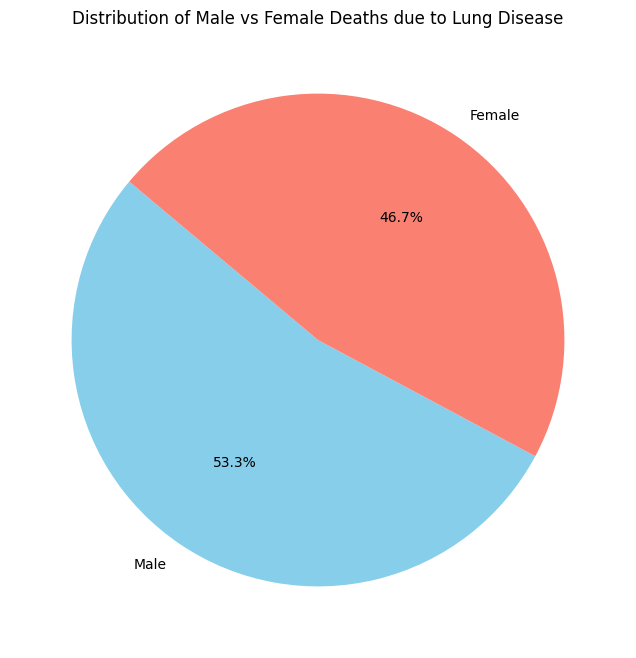

In [17]:
 #Create a pie chart showing the percentage of male vs female patients whose cause of death was lung disease

# Filter out entries with age greater than 120 (Age Unknown populates as a number in the thousands)
filtered_df = lungs_disease_df[lungs_disease_df['detail_age'] <= 120]

# Define age groups for aggregation
# Create age bins of width 10
age_bins = np.arange(0, 121, 10)  

# Create a new column 'age_group' based on the age bins
filtered_df['age_group'] = pd.cut(filtered_df['detail_age'], bins=age_bins, labels=age_bins[:-1])

# Calculate the count of male and female
gender_counts = lungs_disease_df['sex_text'].value_counts()

# Define colors
colors = ['skyblue', 'salmon', 'lightgreen', 'gold', 'lightcoral', 'lightskyblue', 'pink']

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribution of Male vs Female Deaths due to Lung Disease')
# Save the figure
plt.savefig("visuals/Lung_Fig1.png")
plt.show()


In [18]:
#Evalute the difference in males vs females dying of lung disease. Set up Chi-Squared analysis.

#Define groups to obtain data for males and females dying of heart disease
contingency_table = pd.crosstab(index=lungs_disease_df["sex_text"], columns="count")
contingency_table

#Define observed data (from lung_disease_df)
observed = pd.Series([85465,97520], index=["Female", "Male"])

#Create a new dataframe
chi_sq_lung_disease = pd.DataFrame([observed]).T

#Add column with expected values (should be equal: (85465+97520)/2 = 173092.5
chi_sq_lung_disease[1] = 91492

#Rename columns
chi_sq_lung_disease.columns = ["observed", "expected"]

# The degree of freedom is 2-1 = 1
# With a p-value of 0.05, the confidence level is 1.00-0.05 = 0.95.
critical_value = stats.chi2.ppf(q = 0.95, df = 2)

print(f"Critical value: {(critical_value)}")

Critical value: 5.991464547107979


In [19]:
# Create a mapping dictionary for sex
sex_mapping = {1: 'Male', 2: 'Female'}

# Map the values in the 'SEX' column using the mapping dictionary
pop_data_2005_df['SEX'] = pop_data_2005_df['SEX'].map(sex_mapping)

# Display the updated DataFrame
print(pop_data_2005_df)

              NAME  AGE     SEX  POPESTIMATE2005
87   United States    0    Male          2047711
88   United States    1    Male          2036538
89   United States    2    Male          2020295
90   United States    3    Male          2012820
91   United States    4    Male          2058231
..             ...  ...     ...              ...
255  United States   81  Female           742630
256  United States   82  Female           683339
257  United States   83  Female           648391
258  United States   84  Female           595097
259  United States   85  Female          3249455

[172 rows x 4 columns]


In [20]:
# Group by 'SEX' column and sum the 'POPESTIMATE2005' column
population_by_sex = pop_data_2005_df.groupby('SEX')['POPESTIMATE2005'].sum()

# Display the total population by sex
print(population_by_sex)

SEX
Female    150319521
Male      145197078
Name: POPESTIMATE2005, dtype: int64


In [21]:
# Calculate the total population
total_population = population_by_sex.sum()

# Calculate the percentage of the total population for each sex
population_percentage_by_sex = (population_by_sex / total_population) * 100

# Display the percentage of the total population for males and females
population_percentage_by_sex

SEX
Female    50.866693
Male      49.133307
Name: POPESTIMATE2005, dtype: float64

In [22]:
#Determine if percentages of male vs female dying from lung disease align with total population percentages. 
#Calculate percent difference between the affected and population percentages

# Total population of males vs affected males
male_pcnt_diff = ((abs(49.1 - male_count))/male_count) * 100

# Total population of females vs affected females
female_pcnt_diff = ((abs(50.9 - female_count))/female_count) * 100

print(f"The percent difference between the total male population and the affected male population is: {male_pcnt_diff:.2f}%")
print(f"The percent difference between the total female population and the affected female population is: {female_pcnt_diff:.2f}%")

The percent difference between the total male population and the affected male population is: 99.95%
The percent difference between the total female population and the affected female population is: 99.94%


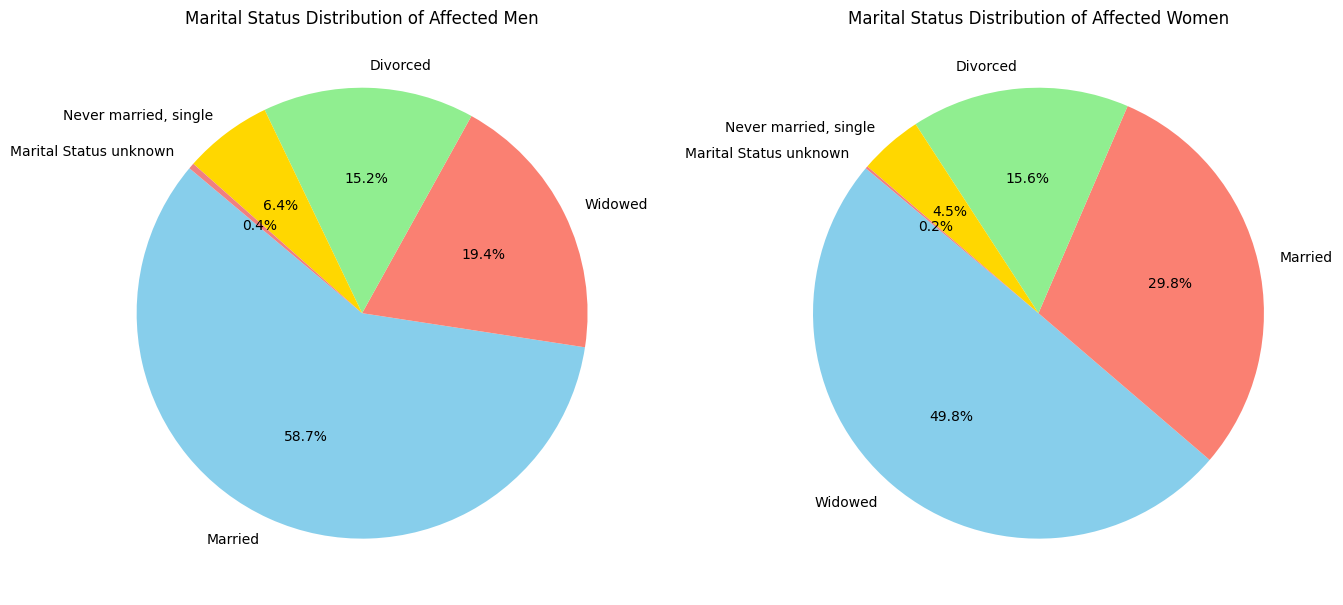

In [23]:
#Is there a relationship between the marital status of individuals and dying of lung disease?

# Filter for sex in the dataset
men_df = filtered_df[filtered_df['sex_text'] == 'Male']
women_df = filtered_df[filtered_df['sex_text'] == 'Female']

# Calculate the count of marital statuses for each sex
men_marital_counts = men_df['marital_status_text'].value_counts()
women_marital_counts = women_df['marital_status_text'].value_counts()

# Create pie charts, per sex, with different colors for each marital status
colors = ['skyblue', 'salmon', 'lightgreen', 'gold', 'lightcoral', 'lightskyblue', 'lightpink']

# Create subplots for male and female pie charts
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot pie chart for men
axs[0].pie(men_marital_counts, labels=men_marital_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
axs[0].set_title('Marital Status Distribution of Affected Men')

# Plot pie chart for women
axs[1].pie(women_marital_counts, labels=women_marital_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
axs[1].set_title('Marital Status Distribution of Affected Women')
plt.savefig("visuals/Lung_Fig2.png")
plt.show()

In [24]:
# Find mean , median and mode of lung disease by Age
average_male_count = lungs_disease_df[lungs_disease_df['sex_text'] == 'Male']['detail_age'].mean()
average_female_count = lungs_disease_df[lungs_disease_df['sex_text'] == 'Female']['detail_age'].mean()

median_male_count = lungs_disease_df[lungs_disease_df['sex_text'] == 'Male']['detail_age'].median()
median_female_count = lungs_disease_df[lungs_disease_df['sex_text'] == 'Female']['detail_age'].median()

mode_male_count = lungs_disease_df[lungs_disease_df['sex_text'] == 'Male']['detail_age'].mode()
mode_female_count = lungs_disease_df[lungs_disease_df['sex_text'] == 'Female']['detail_age'].mode()

print(f"Average age for males: {average_male_count:.0f}")
print(f"Average age for females: {average_female_count:.0f}")
print (f"-----------------------------------------------")
print(f"Median age for males: {median_male_count:.0f}")
print(f"Median age for females: {median_female_count:.0f}")
print (f"-----------------------------------------------")
print(f"Mode age for males: {mode_male_count:}")
print(f"Mode age for females: {mode_female_count:}")

Average age for males: 72
Average age for females: 74
-----------------------------------------------
Median age for males: 74
Median age for females: 76
-----------------------------------------------
Mode age for males: 0    77
Name: detail_age, dtype: int64
Mode age for females: 0    80
Name: detail_age, dtype: int64


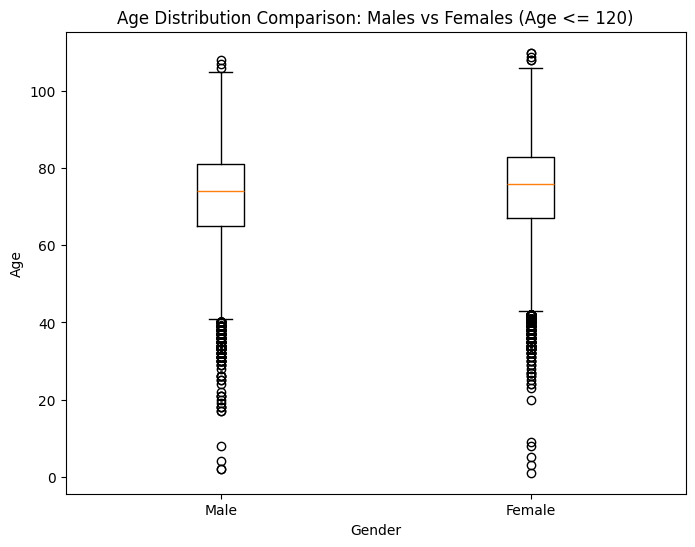

In [25]:
#Create a box and whisker plot to demonstrate the affected
# Filter the heart disease dataframe for males and females, excluding age values above 120
male_data = lungs_disease_df.loc[(lungs_disease_df['sex_text'] == 'Male') & (lungs_disease_df['detail_age'] <= 120), 'detail_age']
female_data = lungs_disease_df.loc[(lungs_disease_df['sex_text'] == 'Female') & (lungs_disease_df['detail_age'] <= 120), 'detail_age']

# Create a box and whisker plot for males vs females with age values below 120
plt.figure(figsize=(8, 6))
plt.boxplot([male_data, female_data], labels=['Male', 'Female'])
plt.title('Age Distribution Comparison: Males vs Females (Age <= 120)')
plt.xlabel('Gender')
plt.ylabel('Age')

plt.savefig("visuals/Lung_Fig3.png")
plt.show()

When evaluating the mean, median or mode between males and females...in each case, females outlive their males conterparts by 3 to 8 years.
Additional evaluation is required to determine if this holds true for each subcategory of lung disease leading to death.

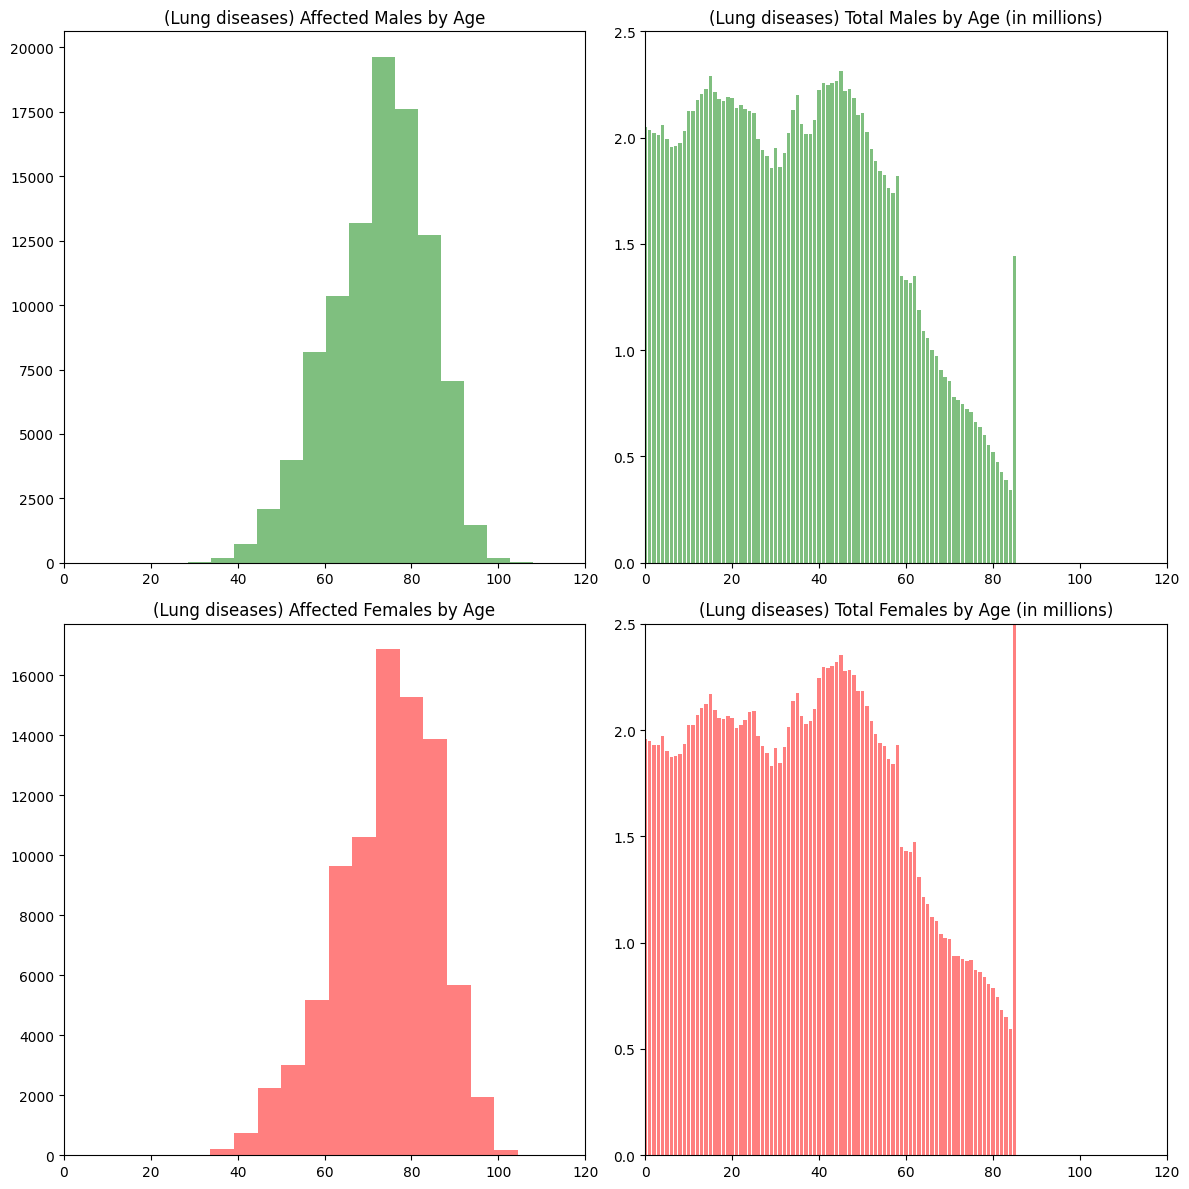

In [26]:
# Filter the lung disease dataframe for affected individuals and drop age values above 120
male_heart_disease_df = lungs_disease_df[(lungs_disease_df['sex_text'] == 'Male') & (lungs_disease_df['detail_age'] <= 120)]
female_heart_disease_df = lungs_disease_df[(lungs_disease_df['sex_text'] == 'Female') & (lungs_disease_df['detail_age'] <= 120)]

# Filter the population dataframe for the year 2005 and drop age values above 120
male_pop_2005_df = pop_data_2005_df[(pop_data_2005_df['SEX'] == 'Male') & (pop_data_2005_df['AGE'] <= 120)]
female_pop_2005_df = pop_data_2005_df[(pop_data_2005_df['SEX'] == 'Female') & (pop_data_2005_df['AGE'] <= 120)]

# Create subplots for male histograms side by side and female histograms below the males
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot affected males on the left
axs[0, 0].hist(male_heart_disease_df['detail_age'], bins=20, color='green', alpha=0.5)
axs[0, 0].set_title('(Lung diseases) Affected Males by Age')
axs[0, 0].set_xlim(0, 120)

# Plot total males on the right with bar heights based on population estimates in millions
axs[0, 1].bar(male_pop_2005_df['AGE'], male_pop_2005_df['POPESTIMATE2005'] / 1000000, color='green', alpha=0.5)
axs[0, 1].set_title('(Lung diseases) Total Males by Age (in millions)')
axs[0, 1].set_xlim(0, 120)
axs[0, 1].set_ylim(0, 2.5)
axs[0, 1].set_yticks(np.arange(0, 2.6, 0.5))

# Plot affected females below affected males
axs[1, 0].hist(female_heart_disease_df['detail_age'], bins=20, color='red', alpha=0.5)
axs[1, 0].set_title('(Lung diseases) Affected Females by Age')
axs[1, 0].set_xlim(0, 120)

# Plot total females below total males with bar heights based on population estimates in millions
axs[1, 1].bar(female_pop_2005_df['AGE'], female_pop_2005_df['POPESTIMATE2005'] / 1000000, color='red', alpha=0.5)
axs[1, 1].set_title('(Lung diseases) Total Females by Age (in millions)')
axs[1, 1].set_xlim(0, 120)
axs[1, 1].set_ylim(0, 2.5)
axs[1, 1].set_yticks(np.arange(0, 2.6, 0.5))
plt.savefig("visuals/Lung_Fig4.png")
plt.tight_layout()
plt.show()

# Conclusion:
Based on the provided information, it appears that there is a notable difference in the mortality rates due to lung diseases between men and women, particularly in their seventies. Here's a detailed breakdown of the conclusion:

Peak Age Difference: The peak age for lung disease-related deaths shows a significant difference between men and women, with the disparity being most noticeable in their seventies. This implies that individuals in their seventies, especially men, are more susceptible to lung diseases leading to mortality.

Lung Disease Mortality: The data indicates that a considerable number of deaths among both men and women are attributed to lung diseases. However, there is a disparity in the numbers, with a higher mortality rate among men. Specifically, 61,648 men and 58,421 women died due to lung diseases. This suggests that lung diseases contribute significantly to mortality, especially among men.

## 2. Is there a relationship between age and dying of Lung disease in the US?

In [27]:
#Group the total population data into 5 year ag groups and calculate the population total for each age group

# Create a new column to represent the five-year age groups
pop_data_2005_df['Five_Year_Frame'] = (pop_data_2005_df['AGE'] // 5) * 5

# Group the data by five-year age groups and calculate the sum of "POPESTIMATE2005"
pop_result = pop_data_2005_df.groupby('Five_Year_Frame')['POPESTIMATE2005'].sum()

# Display the result showing the sum for each five-year age group
print(pop_result)

Five_Year_Frame
0     19917400
5     19389067
10    21212579
15    21486214
20    20959955
25    19534710
30    19723937
35    20798653
40    22706885
45    22417171
50    20078733
55    17503220
60    13138277
65    10278627
70     8603070
75     7463609
80     5611193
85     4693299
Name: POPESTIMATE2005, dtype: int64


In [28]:
# Group the affected popoulation data into 5-year age groups and calculate the affected population total for each age group

# Create a new column to represent the five-year age group
lungs_disease_df['Five_Year_Age_Group'] = (lungs_disease_df['detail_age'] // 5) * 5

# Group the data by five-year age groups and calculate the count for each group
aff_result = lungs_disease_df.groupby('Five_Year_Age_Group').size()

# Display the count for each five-year age group
print(aff_result)

Five_Year_Age_Group
0          5
5          4
15         6
20        10
25        19
30        75
35       373
40      1488
45      3830
50      6802
55     11238
60     17169
65     21897
70     28098
75     33110
80     29596
85     18648
90      8273
95      2085
100      236
105       15
110        2
995        6
dtype: int64


In [29]:
#Determine rate of death by age group

# Step 3: Calculate the death rate per 1000 people for each age group
death_rate_per_1000 = (aff_result / pop_result) * 1000

# Display the death rate per 1000 people for each five-year age group
print(death_rate_per_1000)

0      0.000251
5      0.000206
10          NaN
15     0.000279
20     0.000477
25     0.000973
30     0.003802
35     0.017934
40     0.065531
45     0.170851
50     0.338766
55     0.642053
60     1.306792
65     2.130343
70     3.266043
75     4.436192
80     5.274458
85     3.973325
90          NaN
95          NaN
100         NaN
105         NaN
110         NaN
995         NaN
dtype: float64


In [30]:
#Remove data for ages > 85 (Census has no general population data available over this age so no rate of death can be calculated)

# Filter out data above age 85
death_rate_per_1000_filtered = death_rate_per_1000[death_rate_per_1000.index <= 85]

# Display the death rate per 1000 people for each five-year age group below or equal to 85
print(death_rate_per_1000_filtered)

0     0.000251
5     0.000206
10         NaN
15    0.000279
20    0.000477
25    0.000973
30    0.003802
35    0.017934
40    0.065531
45    0.170851
50    0.338766
55    0.642053
60    1.306792
65    2.130343
70    3.266043
75    4.436192
80    5.274458
85    3.973325
dtype: float64


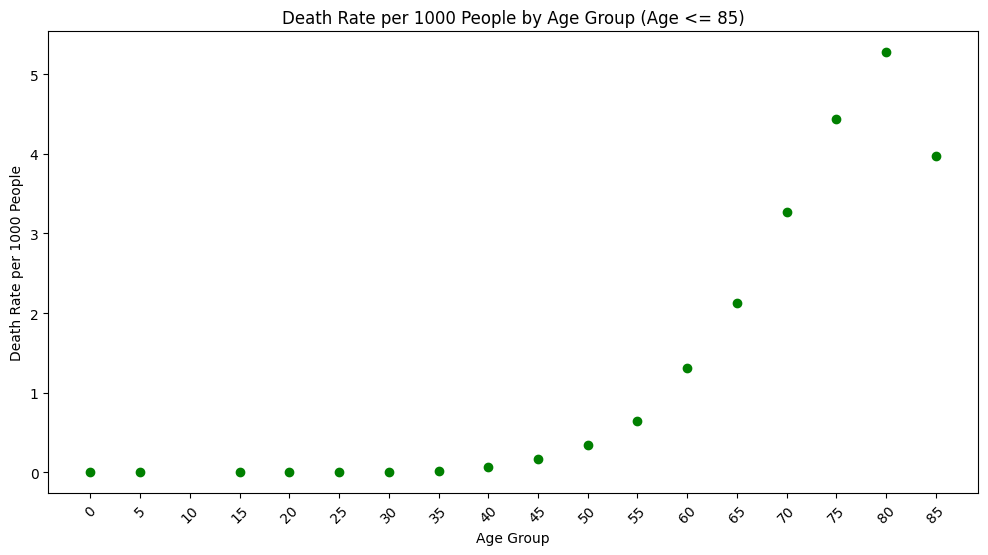

In [31]:
# Create a scatter plot of the rate of death (per 1000 people in total population) due to lung disease

plt.figure(figsize=(12, 6))
plt.scatter(death_rate_per_1000_filtered.index, death_rate_per_1000_filtered, color='g', label='Death Rate per 1000')
plt.title('Death Rate per 1000 People by Age Group (Age <= 85)')
plt.xlabel('Age Group')
plt.ylabel('Death Rate per 1000 People')
plt.xticks(death_rate_per_1000_filtered.index, rotation=45)
plt.savefig("visuals/Lung_Fig5.png")
plt.show()


R-squared value: nan


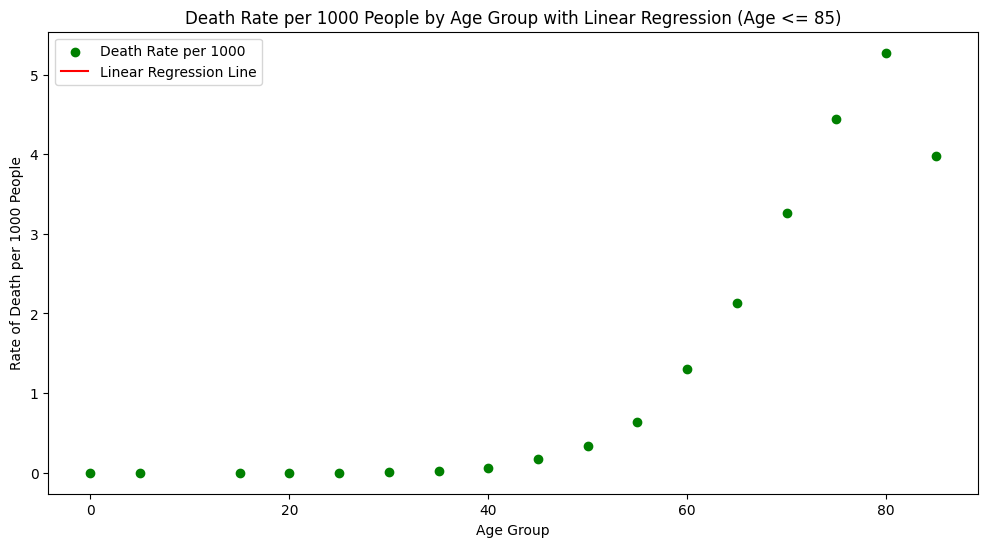

In [32]:
#Determine if there is a relationship between age and rate of death due to lung disease using linear regression analysis

# Calculate the linear regression line

slope, intercept, r_value, p_value, std_err = linregress(death_rate_per_1000_filtered.index, death_rate_per_1000_filtered)
regression_line = slope * death_rate_per_1000_filtered.index + intercept

# Calculate R-squared value
r_squared = r_value ** 2
print(f"R-squared value: {r_squared}")

# Create a scatter plot with the linear regression line
plt.figure(figsize=(12, 6))
plt.scatter(death_rate_per_1000_filtered.index, death_rate_per_1000_filtered, color='g', label='Death Rate per 1000')
plt.plot(death_rate_per_1000_filtered.index, regression_line, color='r', label='Linear Regression Line')
plt.title('Death Rate per 1000 People by Age Group with Linear Regression (Age <= 85)')
plt.xlabel("Age Group")
plt.ylabel("Rate of Death per 1000 People")
plt.legend()
plt.savefig("visuals/Lung_Fig6.png")
plt.show()

In [33]:
#Apply curve fit.

# Define a polynomial function for curve fitting
def polynomial_func(x, a, b, c):
    return a * x**2 + b * x + c

# Perform curve fitting to find the coefficients of the polynomial
popt, _ = curve_fit(polynomial_func, death_rate_per_1000_filtered.index, death_rate_per_1000_filtered)

# Create a scatter plot of the filtered death rate data
plt.figure(figsize=(12, 6))
plt.scatter(death_rate_per_1000_filtered.index, death_rate_per_1000_filtered, color='b', label='Death Rate per 1000')

# Generate the curve using the fitted polynomial coefficients
curve = polynomial_func(death_rate_per_1000_filtered.index, *popt)

# Plot the curve on the scatter plot
plt.plot(death_rate_per_1000_filtered.index, curve, color='r', label='Curvilinear Regression Curve')
plt.title('Death Rate per 1000 People by Age Group with Linear Regression (Age <= 85)')
plt.xlabel("Age Group")
plt.ylabel("Rate of Death per 1000 People")
plt.legend()
plt.annotate(popt, (0, 100000), color='red')
plt.savefig("visuals/Lung_Fig7.png")
plt.show()

ValueError: array must not contain infs or NaNs

In [ ]:
#Calculate the "Goodness of Fit" and corresponding R-squared value.

# Calculate the residuals
residuals = death_rate_per_1000_filtered - polynomial_func(death_rate_per_1000_filtered.index, *popt)

# Calculate the total sum of squares
ss_total = np.sum((death_rate_per_1000_filtered - np.mean(death_rate_per_1000_filtered))**2)

# Calculate the residual sum of squares
ss_res = np.sum(residuals**2)

# Calculate the R-squared value
r_squared = 1 - (ss_res / ss_total)

print(f"The R-squared value is: {r_squared}")#Determine the statistical significance of the R-2 value.

# Calculate the number of data points
n = len(death_rate_per_1000_filtered)

# Calculate the number of parameters in the model (assuming 3 for a quadratic curve)
k = 3

# Calculate the degrees of freedom for the model
df_model = k - 1

# Calculate the degrees of freedom for the residuals
df_resid = n - k

# Calculate the F-statistic
F = (r_squared / df_model) / ((1 - r_squared) / df_resid)

# Calculate the p-value associated with the F-statistic
p_value = 1 - stats.f.cdf(F, df_model, df_resid)

print(f"The p-value associated with the R-squared value is: {p_value}")

In [ ]:
#Determine the statistical significance of the R-2 value.

# Calculate the number of data points
n = len(death_rate_per_1000_filtered)

# Calculate the number of parameters in the model (assuming 3 for a quadratic curve)
k = 3

# Calculate the degrees of freedom for the model
df_model = k - 1

# Calculate the degrees of freedom for the residuals
df_resid = n - k

# Calculate the F-statistic
F = (r_squared / df_model) / ((1 - r_squared) / df_resid)

# Calculate the p-value associated with the F-statistic
p_value = 1 - stats.f.cdf(F, df_model, df_resid)

print(f"The p-value associated with the R-squared value is: {p_value}")

## 3. Is there a relationship between race and deaths due to lung disease in the US?

In [ ]:
# Create a histogram of deaths due to lung disease by race

plt.figure(figsize=(12, 6))
lungs_disease_df['race_recode_5_text'].value_counts().plot(kind='bar', color='firebrick')
plt.title('Number of Deaths by Race')
plt.xlabel('Race')
plt.ylabel('Number of Deaths')
plt.xticks(rotation=90)
plt.savefig("visuals/Lung_Fig8.png")
plt.show()

# Conclusion

Other Contributing Factors: While lung diseases are a significant cause of mortality among both men and women, other common illnesses may also contribute to mortality rates. The data suggests that certain illnesses may be more aggressive among men compared to women, leading to higher mortality rates. However, it's important to note that women also face mortality risks from other illnesses, albeit potentially less severe than those affecting men.

Life Expectancy: Despite the differences in mortality rates and causes of death, women tend to have a higher life expectancy compared to men. This suggests that while women may face mortality risks from various illnesses, they have a higher likelihood of living into their eighties compared to men.

Overall, the conclusion highlights the significant impact of lung diseases on mortality rates, particularly among individuals in their seventies. It also underscores the importance of considering gender differences in understanding mortality patterns and identifying potential contributing factors to address health disparities.